# Question 4

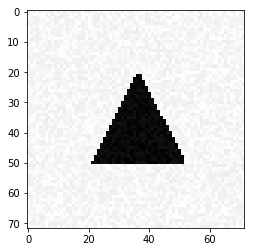

In [1]:
# preliminary code

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72, 72), cmap='gray')


im = generate_a_disk(10)
plt.imshow(im.reshape(72, 72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72, 72), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]


In [2]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.
/Users/Jean/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# generate training data
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [14]:
# Format
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 3)

In [5]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')

In [8]:
# create X_test
(X_test, Y_test) = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [9]:
# format
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')
np.shape(X_test)

(300, 72, 72, 1)

In [10]:
### build CNN model

# convolutional layer
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
model = None
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model.output_shape)

(None, 68, 68, 16)


In [11]:
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)
# fully connected layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.output_shape)

(None, 34, 34, 16)
(None, 3)


In [12]:
X_train.shape

(300, 72, 72, 1)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
300/300 [==============================] - 1s 4ms/step - loss: 1.4015 - acc: 0.2900
Epoch 2/50
300/300 [==============================] - 1s 2ms/step - loss: 0.9775 - acc: 0.6400
Epoch 3/50
300/300 [==============================] - 1s 2ms/step - loss: 0.8504 - acc: 0.6900
Epoch 4/50
300/300 [==============================] - 1s 2ms/step - loss: 0.7500 - acc: 0.7700
Epoch 5/50
300/300 [==============================] - 1s 2ms/step - loss: 0.6625 - acc: 0.7867
Epoch 6/50
300/300 [==============================] - 1s 2ms/step - loss: 0.6155 - acc: 0.8033
Epoch 7/50
300/300 [==============================] - 1s 2ms/step - loss: 0.5623 - acc: 0.8000
Epoch 8/50
300/300 [==============================] - 1s 3ms/step - loss: 0.5533 - acc: 0.7900
Epoch 9/50
300/300 [==============================] - 1s 3ms/step - loss: 0.5137 - acc: 0.8433
Epoch 10/50
300/300 [==============================] - 1s 4ms/step - loss: 0.4624 - acc: 0.8533
Epoch 11/50
300/300 [============================

In [17]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.72219189961751307, 0.72666666666666668]

We have an accuracy of 0.72 applying our model to the test set which is lower than the 100% achieved in training
but this would be expected in testing.